In [880]:
import keras
from keras.datasets import mnist
from matplotlib import pyplot
import numpy as np
import sklearn
import sklearn.linear_model
from sklearn.linear_model import LogisticRegression
from keras.utils import to_categorical
from keras.utils import np_utils

%matplotlib inline

np.random.seed(1) # set a seed so that the results are consistent

In [881]:
(train_x, train_y), (test_x, test_y) = mnist.load_data()

In [882]:
print('train_x: ' + str(train_x.shape))
print('train_y: ' + str(train_y.shape))
print('test_x:  '  + str(test_x.shape))
print('test_y:  '  + str(test_y.shape))

train_x: (60000, 28, 28)
train_y: (60000,)
test_x:  (10000, 28, 28)
test_y:  (10000,)


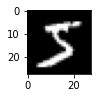

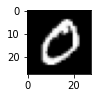

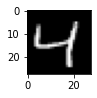

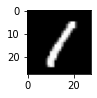

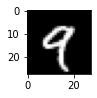

In [883]:
for i in range(5):  
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(train_x[i], cmap=pyplot.get_cmap('gray'))
    pyplot.show()

In [884]:
# This function initializes the parameters of our network
# We will have a network with two layers, thus we need parameters W1 and b1 for
# the first layer and W2 and b2 for the second layer
# Remember that the weights can't be initialized to 0 but rather small random values
# n_x represents the number of input features
# n_h represents the number of hidden units (in the hidden layer)
# n_y represents the number of output units
def init_params(n_x, n_h, n_y):
    np.random.seed(2) 
    W1 = np.random.randn(n_h, n_x)* 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h)* 0.01
    b2 = np.zeros((n_y, 1))
    
    params = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return params

#Flatten 28 by 28 images to a 784 vector for each image
num_pixels = train_x.shape[1] * train_x.shape[2]

train_x = train_x.reshape((train_x.shape[0], num_pixels))
test_x = test_x.reshape((test_x.shape[0], num_pixels))
train_x = train_x.astype('float32')
test_x = test_x.astype('float32')

#Reduce dataset for memory sake
train_x = train_x[: 500]
train_y = train_y[: 500]
test_x = test_x[: 50]
test_y = test_y[: 50]

# normalizing the data to help with the training
train_x /= 255
test_x /= 255

#Categorize y matrices
n_classes = 10
train_y = np_utils.to_categorical(train_y, n_classes)
test_y = np_utils.to_categorical(test_y, n_classes)

#Transpose martices
train_x = train_x.T
train_y = train_y.T
test_x = test_x.T
test_y = test_y.T

print('train_x: ' + str(train_x.shape))
print('train_y: ' + str(train_y.shape))
print('test_x:  '  + str(test_x.shape))
print('test_y:  '  + str(test_y.shape))

train_x: (784, 500)
train_y: (10, 500)
test_x:  (784, 50)
test_y:  (10, 50)


In [885]:
# For ease of use we will store the parameters in a dictionary called params

def sigmoid(x):
    """
    Compute the sigmoid of x
    Arguments:
    x -- A scalar or numpy array of any size.
    Return:
    s -- sigmoid(x)
    """
    s = 1/(1+np.exp(-x))
    return s

# This function performs forward propagation
# it receives as parameters the matrix X containing the input features for the entire training set
# and the paramters of the network in the dictionary params
def forward_propagation(X, params):
    W1 = params['W1']
    b1 = params['b1']
    W2 = params['W2']
    b2 = params['b2']
    Z1 = np.dot(W1, X) + b1
    A1 = sigmoid(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    
    forwd = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, forwd

# We will store the Zi and Ai matrixes in a dictionary called forwd
# for ease of use we will also separately return A2 which corresponds with the output of the network

# Here we compute the cost function over the entire training set
# all we need is the predicted value by the network (Y_pred) 
# and the actual class of the training examples (Y)
def compute_cost(Y_pred, Y):
    m = Y.shape[1] # number of example
    logprobs = np.multiply(np.log(Y_pred),Y) + np.multiply(np.log(1 - Y_pred), (1 - Y))
    cost = - (1/m) * np.sum(logprobs) 
    cost = float(np.squeeze(cost))  # makes sure cost is a real number.
    
    return cost

# This function performs backward propagation
# it calculates dW2, db2, dW1 and db1
def backward_propagation(params, forwd, X, Y):
    m = X.shape[1]
    W1 = params['W1']
    W2 = params['W2']

    A1 = forwd['A1']
    A2 = forwd['A2']
    
    dZ2 = A2 - Y  #dz in slide 10, result of applying the chain rule (see also slide 18)
    dW2 = 1/m*np.dot(dZ2, A1.T)
    db2 = 1/m*np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.multiply(np.dot(W2.T, dZ2), A1 - np.power(A1, 2)) # derivative of the sigmoidal function is a(1-a) see slides 10 and 18
    dW1 = 1/m*np.dot(dZ1, X.T)
    db1 = 1/m*np.sum(dZ1, axis=1, keepdims=True)

    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads
# This function returns the gradients in a dictionary

learn_rate = 0.9

# This function uses the gradients and the learning rate to update the parameters
def update_params(params, grads):
    W1 = params['W1']
    b1 = params['b1']
    W2 = params['W2']
    b2 = params['b2']

    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']

    W1 = W1 - learn_rate*dW1
    b1 = b1 - learn_rate*db1
    W2 = W2 - learn_rate*dW2
    b2 = b2 - learn_rate*db2

    params = {"W1": W1,
                "b1": b1,
                "W2": W2,
                "b2": b2}
    
    return params
# It returns the updated parameters

# Here we create and train the actual Neural Network model
# We receive the dataset features X and classes Y
# we receive the number of hidden units as a hyperparameter (n_h)
# and we also get as a hyperparameter how many iterations to train
def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    np.random.seed(3)
    n_x = X.shape[0]
    n_y = Y.shape[0]

    params = init_params(n_x, n_h, n_y)

    # This loop is to perform the forward and backward iterations
    for i in range(0, num_iterations):
        # Inside the loop all the computations (forward and backward computations) are vectorized
        A2, forwd = forward_propagation(X, params)
        cost = compute_cost(A2, Y)
        grads = backward_propagation(params, forwd, X, Y)
        params = update_params(params, grads)

        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return params
# The method returns the parameters of the network, which is what is learned
# ... and all we need to predict!

# This method uses the learned parameters and a set of input values to perform a prediction
def predict(params, X):
    Y_pred, forwd = forward_propagation(X, params)
    predictions = (Y_pred > 0.5)  # in a binary classification problem we predict 1 if the output (y_pred) is larger than 0.5

    return predictions

In [886]:
#Vary the hidden units n_h by 100, 200, 300, 400, 500
for i in range(0, 500, 100):
    print('\n\nFor n_h = %i\n' %(i))

    # Let's train a neural network with 10 hidden units for 5000 iterations (epochs)
    params = nn_model(train_x, train_y, n_h = i, num_iterations = 5000, print_cost=True)

    # And this is the accuracy we got
    predictions = predict(params, test_x)

    correct_count = 0
    predictions_transpose = predictions.T
    test_y_transpose = test_y.T

    for i in range(predictions.shape[1]):
        if((predictions_transpose[i] == test_y_transpose[i]).all()):
            correct_count += 1

    print ('\n\nAccuracy: %d' % float((correct_count/predictions.shape[1])*100) + '%')



For n_h = 0

Cost after iteration 0: 6.931472
Cost after iteration 1000: 3.238457
Cost after iteration 2000: 3.238457
Cost after iteration 3000: 3.238457
Cost after iteration 4000: 3.238457


Accuracy: 0%


For n_h = 100

Cost after iteration 0: 6.878797
Cost after iteration 1000: 0.021245
Cost after iteration 2000: 0.008142
Cost after iteration 3000: 0.004849
Cost after iteration 4000: 0.003401


Accuracy: 82%


For n_h = 200

Cost after iteration 0: 6.934108
Cost after iteration 1000: 0.021422
Cost after iteration 2000: 0.007896
Cost after iteration 3000: 0.004628
Cost after iteration 4000: 0.003215


Accuracy: 84%


For n_h = 300

Cost after iteration 0: 6.682971
Cost after iteration 1000: 0.020823
Cost after iteration 2000: 0.007633
Cost after iteration 3000: 0.004463
Cost after iteration 4000: 0.003096


Accuracy: 82%


For n_h = 400

Cost after iteration 0: 6.765577
Cost after iteration 1000: 0.022205
Cost after iteration 2000: 0.008042
Cost after iteration 3000: 0.004691
Cost 

###Use tanh as activation function and sigmoid for output layer

In [887]:
#Create tanh function
def tanh(x):
    t = (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))
    return t

#tanh forward propagation
def tanh_forward_propagation(X, params):
    W1 = params['W1']
    b1 = params['b1']
    W2 = params['W2']
    b2 = params['b2']
    Z1 = np.dot(W1, X) + b1
    A1 = tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    
    forwd = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, forwd

# This function performs tanh backward propagation
# it calculates dW2, db2, dW1 and db1
def tanh_backward_propagation(params, forwd, X, Y):
    m = X.shape[1]
    W1 = params['W1']
    W2 = params['W2']

    A1 = forwd['A1']
    A2 = forwd['A2']
    
    dZ2 = A2 - Y  #dz in slide 10, result of applying the chain rule (see also slide 18)
    dW2 = 1/m*np.dot(dZ2, A1.T)
    db2 = 1/m*np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.multiply(np.dot(W2.T, dZ2), 1 - np.power(A1, 2)) # derivative of the sigmoidal function is a(1-a) see slides 10 and 18
    dW1 = 1/m*np.dot(dZ1, X.T)
    db1 = 1/m*np.sum(dZ1, axis=1, keepdims=True)

    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

#tanh nn_model
def tanh_nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    np.random.seed(3)
    n_x = X.shape[0]
    n_y = Y.shape[0]

    params = init_params(n_x, n_h, n_y)

    # This loop is to perform the forward and backward iterations
    for i in range(0, num_iterations):
        # Inside the loop all the computations (forward and backward computations) are vectorized
        A2, forwd = tanh_forward_propagation(X, params)
        cost = compute_cost(A2, Y)
        grads = tanh_backward_propagation(params, forwd, X, Y)
        params = update_params(params, grads)

        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return params

# The method returns the parameters of the network, which is what is learned
# ... and all we need to predict!

# This method uses the learned parameters and a set of input values to perform a prediction
def tanh_predict(params, X):
    Y_pred, forwd = tanh_forward_propagation(X, params)
    predictions = (Y_pred > 0.5)  # in a binary classification problem we predict 1 if the output (y_pred) is larger than 0.5

    return predictions

for i in range(0, 500, 100):
    print('\n\nFor n_h = %i\n' %(i))

    #train model
    params = tanh_nn_model(train_x, train_y, n_h = i, num_iterations = 5000, print_cost=True)

    # And this is the accuracy we got
    predictions = tanh_predict(params, test_x)

    correct_count = 0
    predictions_transpose = predictions.T
    test_y_transpose = test_y.T

    for i in range(predictions.shape[1]):
        if((predictions_transpose[i] == test_y_transpose[i]).all()):
            correct_count += 1

    print ('\n\nAccuracy: %d' % float((correct_count/predictions.shape[1])*100) + '%')



For n_h = 0

Cost after iteration 0: 6.931472
Cost after iteration 1000: 3.238457
Cost after iteration 2000: 3.238457
Cost after iteration 3000: 3.238457
Cost after iteration 4000: 3.238457


Accuracy: 0%


For n_h = 100

Cost after iteration 0: 6.933056
Cost after iteration 1000: 0.013510
Cost after iteration 2000: 0.005787
Cost after iteration 3000: 0.003597
Cost after iteration 4000: 0.002591


Accuracy: 82%


For n_h = 200

Cost after iteration 0: 6.940250
Cost after iteration 1000: 0.012396
Cost after iteration 2000: 0.005162
Cost after iteration 3000: 0.003332
Cost after iteration 4000: 0.002465


Accuracy: 86%


For n_h = 300

Cost after iteration 0: 6.914387
Cost after iteration 1000: 0.008078
Cost after iteration 2000: 0.003793
Cost after iteration 3000: 0.002451
Cost after iteration 4000: 0.001848


Accuracy: 88%


For n_h = 400

Cost after iteration 0: 6.925387
/Users/RobDynac/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by z

###We see that the version of the tanh + sigmoid is more accurate than the sigmoid version when n_h = 300

###Add 2 more layers to the neural network

In [888]:
def init_params_2(n_x, n_h, n_y):
    np.random.seed(2) 
    W1 = np.random.randn(n_h, n_x)* 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_x, n_h)* 0.01
    b2 = np.zeros((n_x, 1))
    W3 = np.random.randn(n_h, n_x)* 0.01
    b3 = np.zeros((n_h, 1))
    W4 = np.random.randn(n_y, n_h)* 0.01
    b4 = np.zeros((n_y, 1))
    
    params = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3,
                  "W4": W4,
                  "b4": b4}
    
    return params

def forward_propagation_2(X, params):
    W1 = params['W1']
    b1 = params['b1']
    W2 = params['W2']
    b2 = params['b2']
    W3 = params['W3']
    b3 = params['b3']
    W4 = params['W4']
    b4 = params['b4']

    Z1 = np.dot(W1, X) + b1
    A1 = sigmoid(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    Z4 = np.dot(W4, A3) + b4
    A4 = sigmoid(Z4)
    
    forwd = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2,
             "Z3": Z3,
             "A3": A3,
             "Z4": Z4,
             "A4": A4,}
    
    return A4, forwd

def update_params_2(params, grads, learn_rate = 1.2):
    W1 = params['W1']
    b1 = params['b1']
    W2 = params['W2']
    b2 = params['b2']
    W3 = params['W3']
    b3 = params['b3']
    W4 = params['W4']
    b4 = params['b4']

    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']
    dW3 = grads['dW3']
    db3 = grads['db3']
    dW4 = grads['dW4']
    db4 = grads['db4']

    W1 = W1 - learn_rate*dW1
    b1 = b1 - learn_rate*db1
    W2 = W2 - learn_rate*dW2
    b2 = b2 - learn_rate*db2
    W3 = W3 - learn_rate*dW3
    b3 = b3 - learn_rate*db3
    W4 = W4 - learn_rate*dW4
    b4 = b4 - learn_rate*db4

    params = {"W1": W1,
                "b1": b1,
                "W2": W2,
                "b2": b2,
                "W3": W3,
                "b3": b3,
                "W4": W4,
                "b4": b4}
    
    return params

def backward_propagation_2(params, forwd, X, Y):
    m = X.shape[1]
    W1 = params['W1']
    W2 = params['W2']
    W3 = params['W3']
    W4 = params['W4']

    A1 = forwd['A1']
    A2 = forwd['A2']
    A3 = forwd['A3']
    A4 = forwd['A4']
    
    dZ4 = A4 - Y  #dz in slide 10, result of applying the chain rule (see also slide 18)
    dW4 = 1/m*np.dot(dZ4, A3.T)
    db4 = 1/m*np.sum(dZ4, axis=1, keepdims=True)
    dZ3 = np.multiply(np.dot(W4.T, dZ4), A3 - np.power(A3, 2)) # derivative of the sigmoidal function is a(1-a) see slides 10 and 18
    dW3 = 1/m*np.dot(dZ3, A2.T)
    db3 = 1/m*np.sum(dZ3, axis=1, keepdims=True)
    dZ2 = np.multiply(np.dot(W3.T, dZ3), A2 - np.power(A2, 2)) # derivative of the sigmoidal function is a(1-a) see slides 10 and 18
    dW2 = 1/m*np.dot(dZ2, A1.T)
    db2 = 1/m*np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.multiply(np.dot(W2.T, dZ2), A1 - np.power(A1, 2)) # derivative of the sigmoidal function is a(1-a) see slides 10 and 18
    dW1 = 1/m*np.dot(dZ1, X.T)
    db1 = 1/m*np.sum(dZ1, axis=1, keepdims=True)

    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2,
             "dW3": dW3,
             "db3": db3,
             "dW4": dW4,
             "db4": db4,}
    
    return grads

def nn_model_2(X, Y, n_h, num_iterations = 10000, print_cost=False):
    np.random.seed(3)
    n_x = X.shape[0]
    n_y = Y.shape[0]

    params = init_params_2(n_x, n_h, n_y)

    # This loop is to perform the forward and backward iterations
    for i in range(0, num_iterations):
        # Inside the loop all the computations (forward and backward computations) are vectorized
        A4, forwd = forward_propagation_2(X, params)
        cost = compute_cost(A4, Y)
        grads = backward_propagation_2(params, forwd, X, Y)
        params = update_params_2(params, grads)

        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return params

def predict_2(params, X):
    Y_pred, forwd = forward_propagation_2(X, params)
    predictions = (Y_pred > 0.5)  # in a binary classification problem we predict 1 if the output (y_pred) is larger than 0.5

    return predictions

for i in range(0, 500, 100):
    print('\n\nFor n_h = %i\n' %(i))

    params = nn_model_2(train_x, train_y, n_h = i, num_iterations = 5000, print_cost=True)

    # And this is the accuracy we got
    predictions = predict_2(params, test_x)

    correct_count = 0
    predictions_transpose = predictions.T
    test_y_transpose = test_y.T

    for i in range(predictions.shape[1]):
        if((predictions_transpose[i] == test_y_transpose[i]).all()):
            correct_count += 1

    print ('Accuracy: %d' % float((correct_count/predictions.shape[1])*100) + '%')



For n_h = 0

Cost after iteration 0: 6.931472
Cost after iteration 1000: 3.238457
Cost after iteration 2000: 3.238457
Cost after iteration 3000: 3.238457
Cost after iteration 4000: 3.238457
Accuracy: 0%


For n_h = 100

Cost after iteration 0: 6.857176
Cost after iteration 1000: 3.238457
Cost after iteration 2000: 3.238457
Cost after iteration 3000: 3.238457
Cost after iteration 4000: 3.238457
Accuracy: 0%


For n_h = 200

Cost after iteration 0: 6.986824
Cost after iteration 1000: 3.238457
Cost after iteration 2000: 3.238457
Cost after iteration 3000: 3.238456
Cost after iteration 4000: 3.238456
Accuracy: 0%


For n_h = 300

Cost after iteration 0: 6.892187
Cost after iteration 1000: 3.238457
Cost after iteration 2000: 3.238457
Cost after iteration 3000: 3.238457
Cost after iteration 4000: 3.238456
Accuracy: 0%


For n_h = 400

Cost after iteration 0: 6.827721
Cost after iteration 1000: 3.238457
Cost after iteration 2000: 3.238456
Cost after iteration 3000: 3.238456
Cost after itera